In the previous notebook we set up a HMM and forward computing process. This one will extend that idea, with a few differences. 

In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

In [61]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using Apple M1/M2 GPU via MPS")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not available, falling back to CPU")
# experimenting with torch
# unsqueeze function
x = torch.tensor([1, 2, 3, 4])
c = torch.unsqueeze(x, 0)  # adds a dimension at index 0
print(c)
b = torch.unsqueeze(x, 1)  # adds a dimension at index 1
print(b)

       # Hidden State Ha   Hb    Hc
transition_matrix = torch.tensor([[0.9,0.05,0.05],
                     [0.05,0.9,0.05],
                     [0.05,0.05,0.9]])

       # emissions  # A   B    C
emission_matrix = torch.tensor([[0.9,0.05,0.05],
                     [0.05,0.9,0.05],
                     [0.05,0.05,0.9]])


pi = torch.tensor([0.3,0.4,0.3])

eta = torch.tensor([0.9,0.05,0.05])

✅ Using Apple M1/M2 GPU via MPS
tensor([[1, 2, 3, 4]])
tensor([[1],
        [2],
        [3],
        [4]])


Now imagine the state and symbols are mixed into a single matrix. Design this matrix M to be able to update once every transition, that transform the current mixed state to a linear combination of it, which is the updated mixed state. Because M already inform us about the probability distribution, the update should include the symbol, and we choose one of the three msp matrix to update the probability. 

In [62]:
def compute_msp_matrices(A: torch.Tensor, B: torch.Tensor):
    """
    Given HMM transition matrix A [N, N] and emission matrix B [N, M],
    return a list of MSP matrices T_k, one for each observation symbol k.
    """
    N, M = B.shape
    T_list = []
    
    for k in range(M):  # loop over observation symbols
        emission_col = B[:, k]                      # shape (N,)
        T_k = A * emission_col.unsqueeze(0)         # broadcast multiply to shape (N, N)
        T_list.append(T_k)
    print("T_list:", T_list)
    return T_list  # list of [N x N] tensors, each is T_k

def generate_store_token_belief(T_list,pi:torch.tensor,eta,cycle,seed=None):
     token = []
     belief = []
     store = []
     eta = eta
     print("pi:", pi.shape[0])
     if seed is not None:
          torch.manual_seed(seed)
     for _ in range(cycle):
          dice = np.random.choice(pi.shape[0])
          #print("dice:", dice)
          t_x = T_list[dice]
          
          eta = eta @ t_x
          eta = eta / eta.sum()
          
          token.append(pi[dice])
          belief.append(eta)
          store.append(get_cartesian_from_barycentric(eta))
     token = torch.tensor(token)
     belief = torch.stack(belief)
     return token,belief,store

# helper function
def get_cartesian_from_barycentric(b):
    t = np.transpose(np.array([[0,0],[1,0],[0.5, np.sqrt(3)/2]])) # Triangle
    return t.dot(b)

print(get_cartesian_from_barycentric(eta))
          


[0.075      0.04330127]


In [63]:
t_list = compute_msp_matrices(transition_matrix, emission_matrix)
tokens, beliefs,store = generate_store_token_belief(t_list, pi=pi,eta=eta, cycle=10000)
tokens = tokens.to(device)
beliefs = beliefs.to(device)
print("token.shape:", tokens.shape)
print("example token:", tokens[0:5])
print("belief.shape:", beliefs.shape)
print("example belief:", beliefs[0:5])

T_list: [tensor([[0.8100, 0.0025, 0.0025],
        [0.0450, 0.0450, 0.0025],
        [0.0450, 0.0025, 0.0450]]), tensor([[0.0450, 0.0450, 0.0025],
        [0.0025, 0.8100, 0.0025],
        [0.0025, 0.0450, 0.0450]]), tensor([[0.0450, 0.0025, 0.0450],
        [0.0025, 0.0450, 0.0450],
        [0.0025, 0.0025, 0.8100]])]
pi: 3
token.shape: torch.Size([10000])
example token: tensor([0.3000, 0.3000, 0.4000, 0.3000, 0.3000], device='mps:0')
belief.shape: torch.Size([10000, 3])
example belief: tensor([[0.3168, 0.0360, 0.6472],
        [0.0285, 0.0072, 0.9643],
        [0.0380, 0.5169, 0.4451],
        [0.0099, 0.0591, 0.9310],
        [0.5277, 0.0503, 0.4220]], device='mps:0')


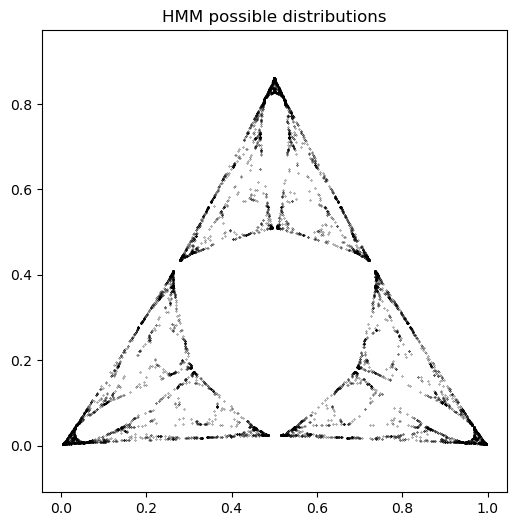

In [64]:
#ploting
store = np.array(store)
plt.figure(figsize=(6, 6))
plt.plot(store[:, 0], store[:, 1], 'k.', markersize=0.5)
plt.axis('equal')
plt.title("HMM possible distributions")
plt.show()

In [74]:
class CNNHMMObserver(nn.Module):
    def __init__(self, vocab_size, emb_dim=32, hidden_dim=64, kernel_size=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.conv1 = nn.Conv1d(in_channels=emb_dim, out_channels=hidden_dim, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=kernel_size, padding=1)
        self.output = nn.Linear(hidden_dim, vocab_size)  # for next-token prediction

    def forward(self, x):
        """
        x: LongTensor of shape [B, T]
        Returns:
            logits: [B, T, vocab_size]
            hidden: [B, T, hidden_dim] ← this is our "residual stream"
        """
        x = self.embedding(x)         # [B, T, D]
        x = x.transpose(1, 2)         # [B, D, T] for Conv1d
        x = F.relu(self.conv1(x))     # [B, H, T]
        #x = F.relu(self.conv2(x))     # [B, H, T]
        x = x.transpose(1, 2)         # [B, T, H] back to standard format
        logits = self.output(x)       # [B, T, vocab_size]
        #print("example logits:", logits[0])
        return logits, x              # logits and internal representation
    

class HMMDataset(Dataset):
    def __init__(self, tokens, beliefs, seq_len=32):
        self.seq_len = seq_len
        self.tokens = tokens
        self.beliefs = beliefs
        self.num_samples = len(tokens) - seq_len

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x = self.tokens[idx : idx + self.seq_len]
        y = self.tokens[idx + 1 : idx + self.seq_len + 1]
        b = self.beliefs[idx + 1 : idx + self.seq_len + 1]
        return x, y, b

In [82]:
tokens = tokens.long()
ds = HMMDataset(tokens, beliefs, seq_len=32)
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)

model = CNNHMMObserver(vocab_size=3)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(0):
    total_loss = 0
    for x, y, _ in dl:
        x = x.to(device)
        y = y.to(device)
        
        logits, _ = model(x)
        loss = F.cross_entropy(logits.view(-1, 3), y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        #print("example logits:", logits[0])
    print(f"Epoch {epoch}: loss = {total_loss:.4f}")

In [83]:
all_reps = []
all_beliefs = []

model.eval()
with torch.no_grad():
    for x, _, b in dl:
        x = x.to(device)
        b = b.to(device)
        _, reps = model(x)           # reps: [B, T, H]
        all_reps.append(reps)
        all_beliefs.append(b)

reps = torch.cat(all_reps, dim=0).reshape(-1, reps.shape[-1])
belief_targets = torch.cat(all_beliefs, dim=0).reshape(-1, 3)

In [84]:


X = reps.detach().cpu().numpy()
Y = belief_targets.detach().cpu().numpy()

probe = LinearRegression()
probe.fit(X, Y)
Y_pred = probe.predict(X)

triangle: tensor([[0.0000, 0.0000],
        [1.0000, 0.0000],
        [0.5000, 0.8660]])
xy_coords: torch.Size([318976, 2])
examples: tensor([[0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5007, 0.2942],
        [0.5008, 0.2943],
        

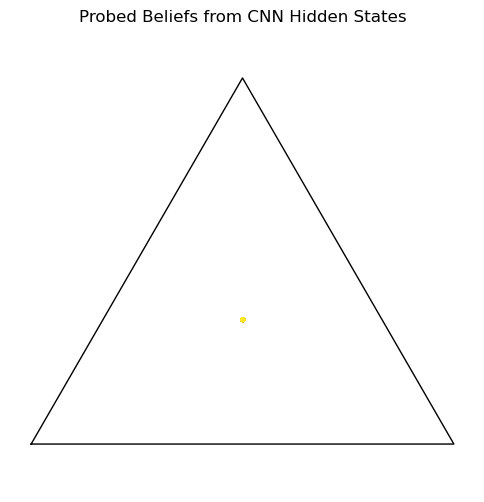

triangle: tensor([[0.0000, 0.0000],
        [1.0000, 0.0000],
        [0.5000, 0.8660]])
xy_coords: torch.Size([318976, 2])
examples: tensor([[0.4832, 0.0249],
        [0.4937, 0.5121],
        [0.1011, 0.0978],
        [0.6637, 0.0507],
        [0.9672, 0.0078],
        [0.7005, 0.4540],
        [0.2805, 0.1796],
        [0.4615, 0.7278],
        [0.4977, 0.8514],
        [0.7410, 0.3958],
        [0.5242, 0.8085],
        [0.5013, 0.8572],
        [0.5001, 0.8602],
        [0.2635, 0.4081],
        [0.0329, 0.0429],
        [0.5440, 0.0406],
        [0.5148, 0.5541],
        [0.8955, 0.1102],
        [0.5911, 0.6684],
        [0.5060, 0.8464],
        [0.5003, 0.8596],
        [0.7382, 0.4055],
        [0.3121, 0.1724],
        [0.4662, 0.7230],
        [0.1334, 0.1863],
        [0.4372, 0.7320],
        [0.7313, 0.3231],
        [0.2294, 0.1047],
        [0.4361, 0.6620],
        [0.0996, 0.1354],
        [0.4172, 0.6938],
        [0.7270, 0.3029],
        [0.0067, 0.0052],
        

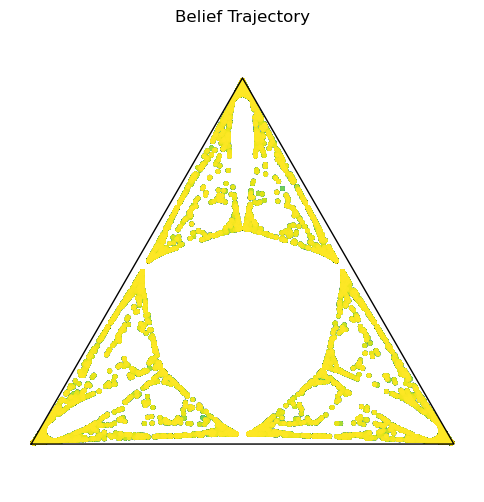

triangle: tensor([[0.0000, 0.0000],
        [1.0000, 0.0000],
        [0.5000, 0.8660]])
xy_coords: torch.Size([318976, 2])
examples: tensor([[0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5008, 0.2943],
        [0.5007, 0.2942],
        [0.5008, 0.2943],
        

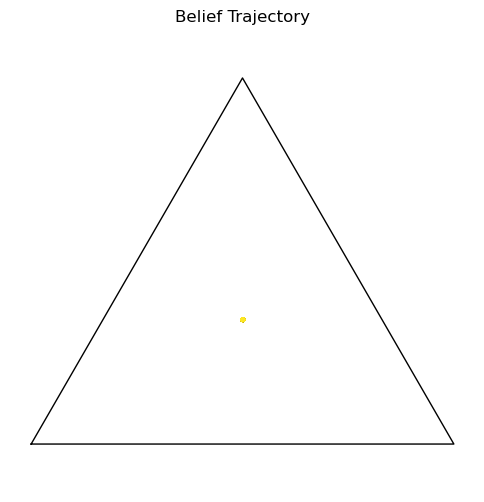

In [86]:
pred_tensor = torch.tensor(Y_pred, dtype=torch.float32)


def plot_beliefs_on_simplex(beliefs: torch.Tensor, title="Belief Trajectory"):
    assert beliefs.shape[1] == 3, "Only works for 3-state HMM"

    # Make triangle float32 to match beliefs
    v0 = torch.tensor([0.0, 0.0], dtype=beliefs.dtype)
    v1 = torch.tensor([1.0, 0.0], dtype=beliefs.dtype)
    v2 = torch.tensor([0.5, torch.sqrt(torch.tensor(3.0, dtype=beliefs.dtype)) / 2], dtype=beliefs.dtype)
    triangle = torch.stack([v0, v1, v2])  # [3, 2]
    print("triangle:", triangle)
    # Convert belief vectors to xy
    xy_coords = beliefs @ triangle  # [T, 2]
    print("xy_coords:", xy_coords.shape)
    print("examples:", xy_coords[0:50])
    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(*zip(*torch.cat([triangle, triangle[0].unsqueeze(0)], dim=0)), color='k', lw=1)
    plt.scatter(xy_coords[:, 0], xy_coords[:, 1], s=6, c=range(len(beliefs)), cmap='viridis')
    plt.title(title)
    plt.axis('equal')
    plt.axis('off')
    plt.show()
plot_beliefs_on_simplex(pred_tensor, title="Probed Beliefs from CNN Hidden States")
plot_beliefs_on_simplex(torch.tensor(Y))
plot_beliefs_on_simplex(torch.tensor(Y_pred))

In [70]:
class ResidualBlock1D(nn.Module):
    def __init__(self, channels, kernel_size=3, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size//2)
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.BatchNorm1d(channels)
        self.norm2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = F.relu(self.conv1(x))
        x = self.norm2(x)
        x = self.dropout(self.conv2(x))
        return F.relu(x + residual)

class ResNet1DObserver(nn.Module):
    def __init__(self, vocab_size, emb_dim=32, hidden_dim=64, num_blocks=4, kernel_size=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.input_proj = nn.Conv1d(emb_dim, hidden_dim, kernel_size=1)

        self.blocks = nn.Sequential(*[
            ResidualBlock1D(hidden_dim, kernel_size=kernel_size) for _ in range(num_blocks)
        ])

        self.output = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        """
        x: [B, T] → token indices
        returns: logits [B, T, vocab_size], and hidden features [B, T, hidden_dim]
        """
        x = self.embedding(x)                  # [B, T, D]
        x = x.transpose(1, 2)                  # [B, D, T]
        x = self.input_proj(x)                 # [B, H, T]
        x = self.blocks(x)                     # [B, H, T]
        x = x.transpose(1, 2)                  # [B, T, H]
        logits = self.output(x)                # [B, T, vocab_size]
        return logits, x

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet1DObserver(vocab_size=3, emb_dim=32, hidden_dim=64, num_blocks=6)
#model.to(device)
tokens = tokens.long()
ds = HMMDataset(tokens, beliefs, seq_len=128)
dl = torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(2):
    total_loss = 0
    for x, y, _ in dl:
        logits, _ = model(x)
        loss = F.cross_entropy(logits.view(-1, 3), y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        #print("example logits:", logits[0])
    print(f"Epoch {epoch}: loss = {total_loss:.4f}")

RuntimeError: Placeholder storage has not been allocated on MPS device!

triangle: tensor([[0.0000, 0.0000],
        [1.0000, 0.0000],
        [0.5000, 0.8660]])
xy_coords: torch.Size([1263616, 2])
examples: tensor([[0.5049, 0.2910],
        [0.5050, 0.2910],
        [0.5050, 0.2911],
        [0.5048, 0.2912],
        [0.5047, 0.2911]])


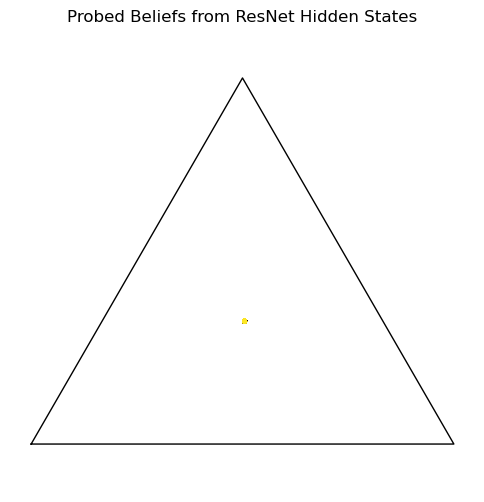

In [ ]:
all_reps = []
all_beliefs = []

model.eval()
with torch.no_grad():
    for x, _, b in dl:
        _, reps = model(x)           # reps: [B, T, H]
        all_reps.append(reps)
        all_beliefs.append(b)

reps = torch.cat(all_reps, dim=0).reshape(-1, reps.shape[-1])
belief_targets = torch.cat(all_beliefs, dim=0).reshape(-1, 3)



X = reps.numpy()
Y = belief_targets.numpy()

probe = LinearRegression()
probe.fit(X, Y)
Y_pred = probe.predict(X)

pred_tensor = torch.tensor(Y_pred, dtype=torch.float32)


plot_beliefs_on_simplex(pred_tensor, title="Probed Beliefs from ResNet Hidden States")